# Dolphin social network analysis and graph convolutional network for clustering in a semi-supervised setting

Complex Networks - M2, 2019


## Introduction

In this project I will conduct a brief analysis of a social network of frequent associations between 62 dolphins in a community living off Doubtful Sound, New Zealand. [1]
The purpose of this analysis is to apply some basic complex network analysis techniques covered during class, e.g. degree distribution and robusteness against attacks, in order to uncover a possible scale-free behaviour. This is not meant to be a thorough study of the mechanisms underlying the dolphin community, partly because of the data being an undirected network with no information regarding sex or age of the animals. On the contrary it will serve as an opportunity to study graph convolutional networks (GCN), a recently developped tool used to analyse structured data, which are able to exploit both network topology and features (e.g. signal on graphs). In this context I will adapt [2] and use this concept to the dolphin network to cluster it in two communities and compare it with a more classical modularity approach.

For the network analysis part I have mainly used the netwrokx library (graph construction and manipulation) and Gephi (for graph visualization and the computation of graph parameters) while for GCN part I relied on the pytorch deep learning library [3] [4].

In [550]:
#import Libraries
import networkx as nx
import pandas as pd
import collections
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from random import choice
import time
import math

import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as F
import torch.optim as optim

## Data source

The data I used is freely available at http://www-personal.umich.edu/~mejn/netdata/.
It is an undirected graph in .gml format, made by 62 nodes and 159 edges. The network was built from a seven years long observation of a dolphin population, where each edge was traced according to the probability of finding two exemplaries together.

### Network construction

I have used the pandas library to import the .csv generated from Gephi.
The random graph model for comparison was built by keeping the same number of nodes and then adding edges randomly until the same number of edges is obtained.

In [551]:
#Data import
dolphins = pd.read_csv("dolphin.csv", index_col="Id").drop("timeset", axis=1)
dolphin_edges = pd.read_csv("dolphin_edge.csv", index_col="Id").drop(columns=["Type","timeset","Label","Weight"], axis=1)

#networkx graph construction
G = nx.Graph()
for i in range(len(dolphins["Label"])):
    G.add_node(i)
G.add_edges_from(list(zip(dolphin_edges.Source, dolphin_edges.Target)))

#random model from original graph (same # of nodes and edges)
n_nodes = len(G.nodes)
n_edges = len(G.edges)
G_rand = nx.gnm_random_graph(n_nodes, n_edges)
nx.write_gexf(G_rand,"rand_graph.gexf")

![dolpvsrand.png](attachment:dolpvsrand.png)

On the left side: the dolphin social network. On the right side: the random graph. Both graphs have been drawn using Gephi and a Force Atlas layout. The darker the node color the higher the node degree.

## Network analysis

|      | Avg. Degree | Graph Density | Diameter | Avg. Path Length | Avg. Clustering Coefficient |
|------|-------------|---------------|----------|------------------|-----------------------------|
|Dolph |   5.129     |     0.084     |     8    |       3.357      |           0.303             |
|Rand  |   5.129     |     0.084     |     5    |       2.636      |           0.092             |

The average degree and graph density are equal by construction. The two networks present similar diameter and average path length, both slightly higher for the dolphin case. Instead, we find a considerably higher average clustering coefficient compared to the random network, a feature found in many social networks, where, for every node, the probability that its neighbours are connected is higher than the random case.

### Degree distribution

By plotting the degree distribution of the graph I check whether I can find some known trend. Given the small number of the nodes it will be impossible to state strong conclusions on the eventual emergent properties of the network.

Text(0.5, 0, 'Degree')

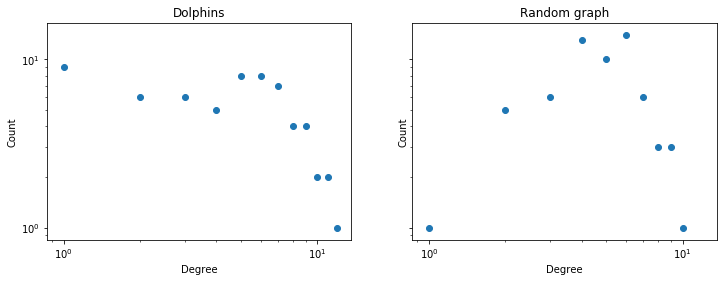

In [521]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

degree_sequence_rand = sorted([d for n, d in G_rand.degree()], reverse=True)  # degree sequence
degreeCount_rand = collections.Counter(degree_sequence_rand)
deg_rand, cnt_rand = zip(*degreeCount_rand.items())

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12,4))
ax1.scatter(deg,cnt)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Dolphins")
ax1.set_ylabel("Count")
ax1.set_xlabel("Degree")

ax2.scatter(deg_rand,cnt_rand)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Random graph")
ax2.set_ylabel("Count")
ax2.set_xlabel("Degree")

On the left side: degree distribution of the dolphin social network. On the right side: degree distribution of the random graph. Both plots are represented in a log-log scale.


While for the random network the plot shows the typical trend of a Poissonian (in log-log), the dolphin network present a seemingly flat distribution for low degrees whereas it "may" follow a power-law for higher degrees. Therefore I have tried to fit a power-law considering only the data points with degrees higher than 7, knowing that eventually the result will be useful only qualitatively for comparison with real-world scale-free networks.

In [467]:
#Power law fitting considering only nodes whose degree was >= 7

def func(x, a, b):
    return -a*x + b

x = np.log(deg[:6])
y = np.log(cnt[:6])
popt, pcov = curve_fit(func, x, y)
print(popt[0])

3.298246700836635


The fitted exponent is around 3.3, which is not really in the scale-free regime but still quite close.

### Robustness to attacks

In order to check the robusteness to attacks of the network I implemented two functions allowing to monitor the average shortest path as nodes are removed, randomly and targeting the highest degree nodes. The computation stops as soon as the graph becomes not connected.

In [546]:
# returns the index of the node whose degree is maximum
def node_max_deg(G):
    deg = dict(G.degree())
    val=list(deg.values())
    k=list(deg.keys())
    return k[val.index(max(val))]

# monitor avg shortest path as nodes are removed
def attack_sim(G,G_rand=None, mode="Random"):
    G_c = G.copy()
    avg_dist = [nx.average_shortest_path_length(G)]
    limit = n_nodes//3
    for i in range(n_nodes//3):
        if mode == "Random":
            G_c.remove_node(choice(list(G_c.nodes)))
        elif mode == "Target":
            G_c.remove_node(node_max_deg(G_c))
        else:
            print("invalid mode")
            return
        try:
            avg_dist.append(nx.average_shortest_path_length(G_c))
        except:
            limit = i+1
            break

    if G_rand is not None:
        G_rand_c = G_rand.copy()
        avg_dist_rand = [nx.average_shortest_path_length(G_rand)]
        limit_rand = n_nodes//3
        for i in range(n_nodes//3):
            if mode == "Random":
                G_rand_c.remove_node(choice(list(G_rand_c.nodes)))
            elif mode == "Target":
                G_rand_c.remove_node(node_max_deg(G_rand_c))
            try:
                avg_dist_rand.append(nx.average_shortest_path_length(G_rand_c))
            except:
                limit_rand = i+1
                break
        plt.scatter(list(range(limit_rand)),avg_dist_rand, label= 'Random')
        
    plt.scatter(list(range(limit)),avg_dist, label= 'Dolphins')
    plt.xlabel("Removed nodes")
    plt.ylabel("Average shortest path")
    plt.title(mode+" attacks")
    plt.legend()
    plt.show()

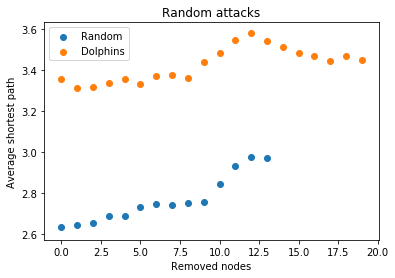

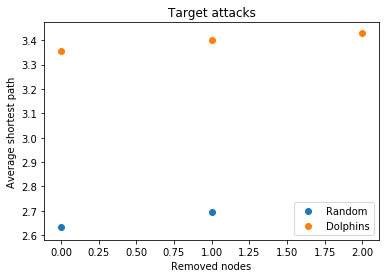

In [548]:
attack_sim(G,G_rand,mode="Random")
attack_sim(G,G_rand,mode="Target")

On the top: Random attack simulation. On the bottom: Targeted (highest degree) attack.

The dolphin network shows a considerable resilience against random attacks, even with a third of nodes removed the graph was still connected. Still, given a high variability of the results obtained during multiple simulations, we can't conclude that its behaviour is remarkably different than a random graph.
The targeted simulation shows that it is sufficient to remove 3 nodes (2% of the total) with the highest degrees to make the graph disconnected.
The average shortest path, generally increases, as nodes are removed but slightly. This is another index of the robustness of the network, not in a strictly topological sense, i.e. information across the community can still flow efficiently (it may be due to the flat degree distribution for d < 7).

### Community structure

By visual inspection, with the aid of the force layout, it seemed plausible that the dolphin population might be divided into two communities. This may not reflect the reality of the situation because of the lack of further information but it will be relevant for the next study with GCNs.

![clus_bet_mod.png](attachment:clus_bet_mod.png)

On the left: the dolphin network highlighting nodes with higher clustering coefficient (computed in Gephi).
In the middle: the dolphin network highlighting nodes with higher betweenness centrality (computed in Gephi).
On the right: the dolphin network divided into two communities using a partition algorithm based on modularity implemented in Gephi [6].

By considering the two leftmost images, we can see that the nodes with highest clustering coefficient are at opposite sides of the graph while those with highest betweenness (an index of how many shortest paths pass through a node) are in the middle. This, along with the degree highlighting graph presented before, suggests a possible community repartition for the dolphin social network.
The graph on the right, obtained by partitioning the graph into two modularity classes, reinforces this intuition.
This partitioning will be used as comparison for the one obtained through the implementation of GCNs on this network.

## Graph Convolutional Network

Graph convolutional network allows for generalization of the concept of CNNs on graph structured data. In the implementation I present a simple version of such neural network (http://tkipf.github.io/graph-convolutional-networks/), where the convolution "can be understood as a graph-structure dependent pooling operation, followed by a linear map and an element-wise non-linearity".

In practice, given a graph, represented as an adjacency matrix A (N x N, with N the number of nodes), and some features associated to each node (globally represented by a matrix X of dimension N x d, where d is the dimension of a feature vector), it is possible to build network layers (in a deep learning context) that combine the information contained in the graph topology (the matrix A) with the information contained in the features (the matrix X).

A possible way to build this layer could be by multiplying the adjacency matrix A (N x N) to the feature matrix X (N x d), then to an adjustable weight matrix W (d x f, where f is the dimension of an output feature vector) and finally applying a non linear function element-wise. The output of such operation will be a matrix X' of dimensions N x f, representing the output feature matrix.

This can be summarized by the following equation: $X' = f(A X W)$ where $f$ is the non-linear function (e.g. ReLU, sigmoid, etc)

As described in [3], one of the problem of this approach is that by using simply the adjacency matrix A, the input feature assigned to each node will not contribute to the output feature of the same node. An easy solution could be to add the identity matrix to A (i.e. adding self loops). Even so, the matrix will not be normalized and therefore it could make the GCN instable when node degrees vary a lot. By premultiplying the matrix (A + I) with the inversed degree matrix D^-1 (considering self-loops) then the problem is solved.

Finally a slight variation is considered where the symmetric version of such matrix is preferred: $D^-1/2  (A+I)  D^-1/2$. In this way we don't simply compute an average over the neighboring nodes.

In [87]:
A = nx.to_numpy_matrix(G)
A = A + np.eye(n_nodes)
D = np.matrix(np.diag([G.degree[i]+1 for i in range(n_nodes)]))
D_inv = np.matrix(np.diag([1/(G.degree[i]+1) for i in range(n_nodes)]))
D_sqrt = np.matrix(np.diag(np.power(np.diag(D),-0.5)))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def gcn_layer(A, D_sqrt, X, W):
    return sigmoid(D_sqrt*A*D_sqrt*X*W)

### Output of untrained GCN

Once the passege from input to output is defined, to construct a multiple layer architecture it's sufficient to define the weight matrices appropriately. To make it clearer I construct a 2 layer GCN considering the dolphin network. Since in the end we would like to get the partitioning into 2 communities the final output feature vector will be of dimension 2. Arbitrarily I set the dimension of the intermediate (hidden) feature vector to be 8. 
Initially, for explanation purposes, I try to simulate the passage through this GCN by considering an uninformative feature matrix X as the identity matrix, randomly defining the weight matrices and choosing the sigmoid function as the element-wise non linear function to be applied for both layers. In this case W1 will be Nx8 and W2 will be 8x2.

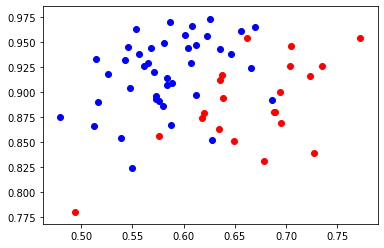

In [206]:
X = np.matrix(np.eye(n_nodes))
W1 = np.random.normal(loc=0, scale=1, size=(n_nodes, 8))
W2 = np.random.normal(loc=0, scale=1, size=(W1.shape[1], 2))

f1 = gcn_layer(A, D_sqrt,X,W1)
f2 = gcn_layer(A, D_sqrt,f1,W2)
out = np.array(f2)

for i in range(n_nodes):
    if dolphins.loc[i,"modularity_class"] == 0:
        color = 'b'
    elif dolphins.loc[i,"modularity_class"] == 1:
        color = 'r'
    plt.scatter(out[i,0],out[i,1],color=color)

In the plot, the two output features of the GCN are represented, one per axis. In blue the nodes belonging the class 0 (white in the previous figure) and in red the nodes belonging to the class 1 (green in the previous figure)

The outcome will depend on the random initialization of the weight matrices but still, even without any training, there is some potential in clustering the graph.

### Pytorch implementation

To train the GCN I decided to use the pytorch deep learning library by modifying the code initially written for a citation network analysis.
By using pytorch it is not necessary to explicitly define weight matrices and the training procedure will be operated after propagating the loss.

It is important now to define what the loss will be: in order for the GCN to learn we need to provide it with labeled (the modularity class) examples. Typically in a machine learning framework the training part will consist of the majority of the nodes. Here I choose to give only two nodes, one per community. The choice fell on the nodes with highest degree, dolphin 14 for the modularity class 0 and dolphin 57 for the modularity class 1. In a real case scenario the choice may be driven by other information, for which it is clear they belong to different communities. Mine was driven solely by experimentation purposes, I am not trying to assert the existence of any alpha-dolphin.

![id.png](attachment:id.png)

The graph showing the node IDs: dolphin 57 is in the lower part while dolphin 14 is on the other side

The reason behind limiting the choice of labeled nodes to just 2 is that for every layer the output feature representation (for the final one a 2D vector, representing the probability of belonging to one class or the other) is produced by "aggregating" both labled and unlabeld neighbors. The loss, specifically the negative log likelihood loss, is calculated from the output feature vector of the 2 labeled nodes, which depends on both label and labeled. Because of this, when backpropagating, the learning taking place can be defined as semi-supervised. [5]

In [339]:
dolphins.index[dolphins['Degree'] == 12].tolist()

[14]

In [340]:
dolphins.index[dolphins['Degree'] == 9].tolist()

[17, 20, 29, 57]

In [384]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [385]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

### Uninformative feature description

Initially we set again an uninformative feature description of the nodes, i.e. the NxN identity matrix.

In [370]:
# in order to use pytorch we need to define all the variables involved as torch Tensors
adj = torch.from_numpy(np.array(D_sqrt*A*D_sqrt))
features = torch.from_numpy(np.eye(n_nodes))
labels = torch.from_numpy(dolphins.modularity_class.values)
idx_train = torch.LongTensor([14,57])
idx_val = torch.LongTensor(range(14))
idx_test = torch.LongTensor(range(15,57))

In [404]:
features = torch.from_numpy(np.eye(n_nodes))

model = GCN(nfeat=features.shape[1],
            nhid=8,
            nclass=labels.max().item() + 1,
            dropout=0.5).float()
optimizer = optim.Adam(model.parameters(),
                       lr=0.01)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features.float(), adj.float())
    
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))
    return output


def test():
    model.eval()
    output = model(features.float(), adj.float())
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    
# Train model
t_total = time.time()
outputs_list = []
for epoch in range(100):
    outputs_list.append(train(epoch))
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

Epoch: 0001 loss_train: 0.6966 acc_train: 0.5000 loss_val: 0.7253 acc_val: 0.4286 time: 0.0040s
Epoch: 0011 loss_train: 0.6222 acc_train: 1.0000 loss_val: 0.6852 acc_val: 0.4286 time: 0.0030s
Epoch: 0021 loss_train: 0.4998 acc_train: 1.0000 loss_val: 0.5796 acc_val: 0.9286 time: 0.0050s
Epoch: 0031 loss_train: 0.3272 acc_train: 1.0000 loss_val: 0.4901 acc_val: 0.9286 time: 0.0010s
Epoch: 0041 loss_train: 0.1445 acc_train: 1.0000 loss_val: 0.3537 acc_val: 0.9286 time: 0.0010s
Epoch: 0051 loss_train: 0.0953 acc_train: 1.0000 loss_val: 0.2725 acc_val: 0.9286 time: 0.0030s
Epoch: 0061 loss_train: 0.0186 acc_train: 1.0000 loss_val: 0.2436 acc_val: 0.9286 time: 0.0010s
Epoch: 0071 loss_train: 0.0262 acc_train: 1.0000 loss_val: 0.2035 acc_val: 1.0000 time: 0.0020s
Epoch: 0081 loss_train: 0.0051 acc_train: 1.0000 loss_val: 0.1590 acc_val: 1.0000 time: 0.0020s
Epoch: 0091 loss_train: 0.0211 acc_train: 1.0000 loss_val: 0.2079 acc_val: 0.9286 time: 0.0030s
Optimization Finished!
Total time elapse

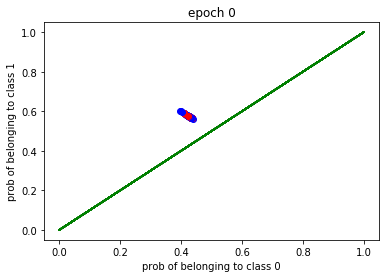

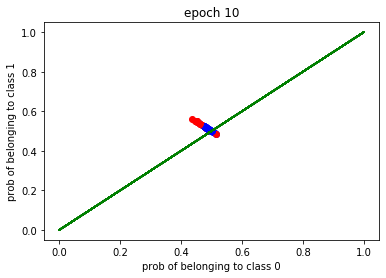

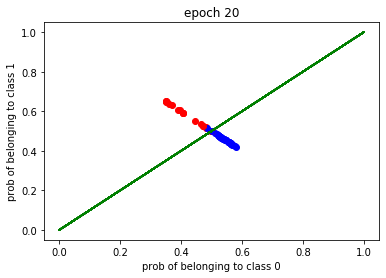

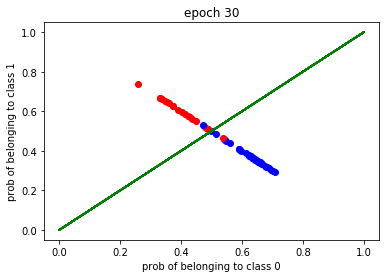

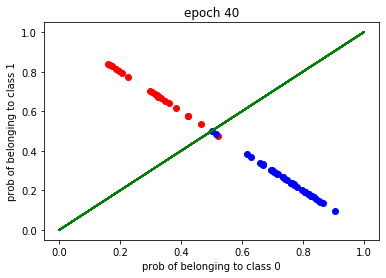

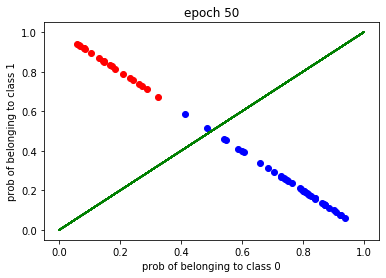

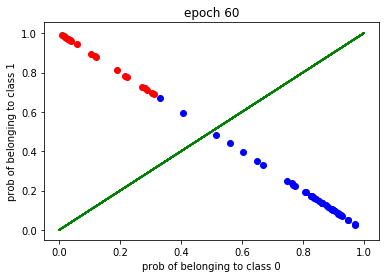

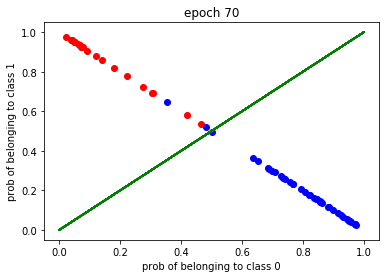

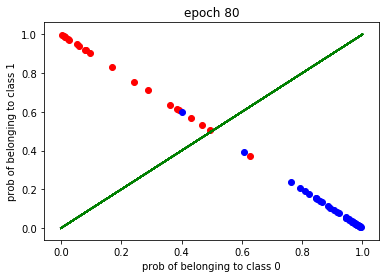

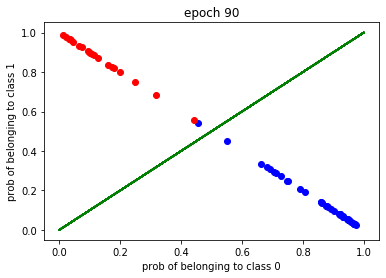

In [410]:
for index in range(0,len(outputs_list),10):
    for i in range(n_nodes):
        if dolphins.loc[i,"modularity_class"] == 0:
            color = 'b'
        elif dolphins.loc[i,"modularity_class"] == 1:
            color = 'r'
        plt.scatter(math.e**outputs_list[index][i,0].tolist(),math.e**outputs_list[index][i,1].tolist(),color=color)
        plt.plot([0,1],[0,1],color='g')
    plt.title("epoch "+str(index))
    plt.xlabel("prob of belonging to class 0")
    plt.ylabel("prob of belonging to class 1")
    plt.show()

In the plots above, the probability for every node of belonging to class 0 (x axis) and to class 1 (y axis) estimated by the GCN. In blue the nodes belonging class 0 and in red the nodes belonging to class 1. The green line denotes the prediction threshold. The training ran for 100 epoch and a plot is represented every 10.


Even with the uninformative feature description the GCN was able to satisfyingly replicate the partitioning obtained with Gephi, which however is not a ground-truth for the communities.

### Augmented feature description

In a real case, such GCN would be used for semi-supervised node classification where there will be actually a feature vector describing each node. That may be a signal on the graph, or for a citation network a binary encoding representing whether a keyword is present in a paper or not.

For the dolphin network, considering the important role dolphin 14 and dolphin 57 had thus far, a significant feature could be represented by the shortest path length separating each node to them. Therefore I repeated the training, this time considering as input features the identity matrix to which the two described columns were added.

In [406]:
short_to14 = []
short_to57 = []
for i in range(n_nodes):
    short_to14.append(nx.shortest_path_length(G,i,14))
    short_to57.append(nx.shortest_path_length(G,i,57))

short_to14 = np.array(short_to14).reshape((62,1))
short_to57 = np.array(short_to57).reshape((62,1))

In [407]:
features = torch.from_numpy(np.hstack((np.eye(n_nodes),short_to14,short_to57)))

model = GCN(nfeat=features.shape[1],
            nhid=8,
            nclass=labels.max().item() + 1,
            dropout=0.5).float()
optimizer = optim.Adam(model.parameters(),
                       lr=0.01)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features.float(), adj.float())
    
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))
    return output


def test():
    model.eval()
    output = model(features.float(), adj.float())
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    
# Train model
t_total = time.time()
outputs_list_sh = []
for epoch in range(100):
    outputs_list_sh.append(train(epoch))
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

Epoch: 0001 loss_train: 0.9315 acc_train: 0.5000 loss_val: 0.8535 acc_val: 0.5714 time: 0.0030s
Epoch: 0011 loss_train: 0.3675 acc_train: 1.0000 loss_val: 0.5244 acc_val: 0.7857 time: 0.0020s
Epoch: 0021 loss_train: 0.0819 acc_train: 1.0000 loss_val: 0.2430 acc_val: 1.0000 time: 0.0070s
Epoch: 0031 loss_train: 0.0743 acc_train: 1.0000 loss_val: 0.2229 acc_val: 1.0000 time: 0.0030s
Epoch: 0041 loss_train: 0.0950 acc_train: 1.0000 loss_val: 0.2339 acc_val: 0.9286 time: 0.0020s
Epoch: 0051 loss_train: 0.0189 acc_train: 1.0000 loss_val: 0.1998 acc_val: 0.9286 time: 0.0030s
Epoch: 0061 loss_train: 0.0016 acc_train: 1.0000 loss_val: 0.1151 acc_val: 1.0000 time: 0.0020s
Epoch: 0071 loss_train: 0.0111 acc_train: 1.0000 loss_val: 0.1294 acc_val: 0.9286 time: 0.0050s
Epoch: 0081 loss_train: 0.0038 acc_train: 1.0000 loss_val: 0.1571 acc_val: 1.0000 time: 0.0040s
Epoch: 0091 loss_train: 0.0330 acc_train: 1.0000 loss_val: 0.1320 acc_val: 1.0000 time: 0.0030s
Optimization Finished!
Total time elapse

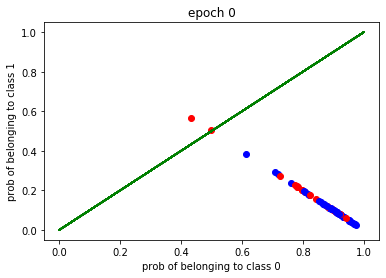

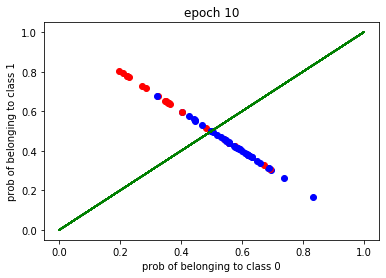

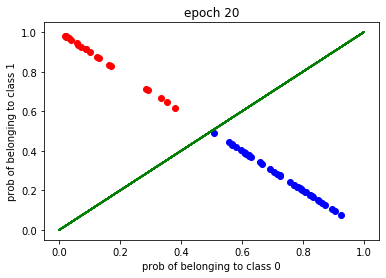

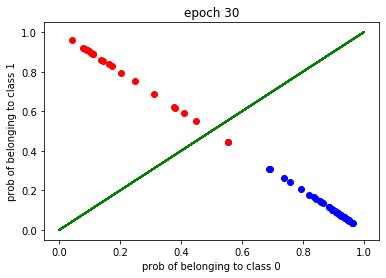

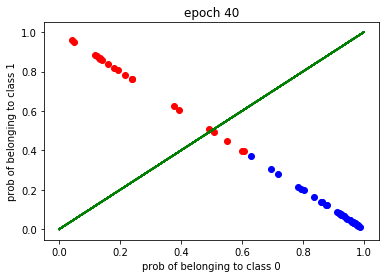

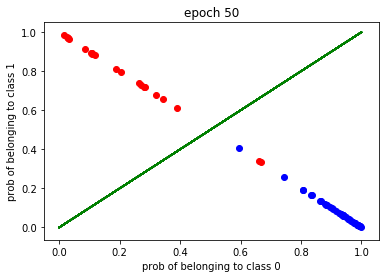

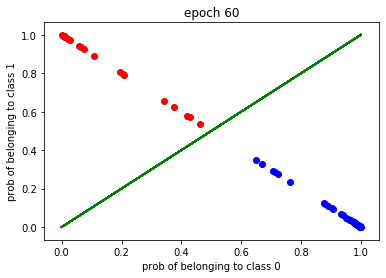

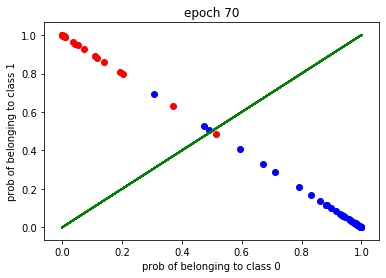

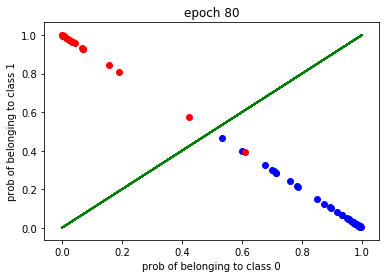

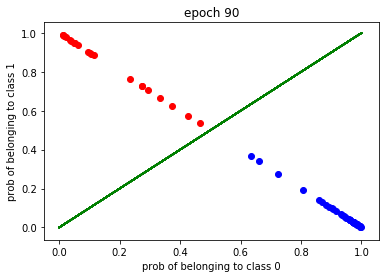

In [411]:
for index in range(0,len(outputs_list_sh),10):
    for i in range(n_nodes):
        if dolphins.loc[i,"modularity_class"] == 0:
            color = 'b'
        elif dolphins.loc[i,"modularity_class"] == 1:
            color = 'r'
        plt.scatter(math.e**outputs_list_sh[index][i,0].tolist(),math.e**outputs_list_sh[index][i,1].tolist(),color=color)
        plt.plot([0,1],[0,1],color='g')
    plt.title("epoch "+str(index))
    plt.xlabel("prob of belonging to class 0")
    plt.ylabel("prob of belonging to class 1")
    plt.show()

In the plots above, the probability for every node of belonging to class 0 (x axis) and to class 1 (y axis) estimated by the GCN. In blue the nodes belonging class 0 and in red the nodes belonging to class 1. The green line denotes the prediction threshold. The training ran for 100 epoch and a plot is represented every 10.

The results obtained are equally satisfying, by comparing with the previous training, we notice a greater concentration close to probability one, meaning that the augmented features could have helped the in the learning process.

## Conclusion

In this project I gave a general analysis of a dolphin social network by comparing it with a generated random graph. The distinguishing properties of the animal network were the higher clustering and considerable resilience to random attacks. The community detection, initially driven by the force layout and node features (degree, clustering coefficient, betweenness), was then obtained via a standard modularity approach and successively via a recently studied method, involving graph convolutional networks. A consistent part of the project was dedicated to study the structure of a GCN for semi-supervised node classification and to learn the basics of the pytorch deep learning library for implementing and adapting the code to the dolphin network case. The GCN method provided results in agreement with the modularity classes obtained before and it has demonstrated to be a relevant technique to be applied in more relevant scenarios.

## References

[1] D. Lusseau, K. Schneider, O. J. Boisseau, P. Haase, E. Slooten, and S. M. Dawson, Behavioral Ecology and Sociobiology 54, 396-405 (2003)

[2] Thomas N. Kipf and Max Welling (2016) Semi-Supervised Classification with Graph Convolutional Networks

[3] http://tkipf.github.io/graph-convolutional-networks/

[4] https://github.com/tkipf/pygcn

[5] https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780

[6] R. Lambiotte, J.-C. Delvenne, M. Barahona Laplacian Dynamics and Multiscale Modular Structure in Networks 2009
